In [1]:
import os
import sys
curDir = os.path.abspath("")
sys.path.append(os.path.join(curDir, "..", "PreProcessing"))
sys.path.append(os.path.join(curDir, "..", "DataAnalysis"))
sys.path.append(os.path.join(curDir, "..", "General"))

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import DataSetBuilder as dataBuilder
from DataLoader import DataLoader
import PrepaymentInfoProvider as ppm

import GraphHelper as gh

import Helpers

In [2]:
years = [2016]
dfOrig = dataBuilder.build_data_set(years=years)


20210530--20:51:02--INFO--Reading adjusted data files


In [3]:
dl = DataLoader()
dfOrigOld, dfMonthly = dl.get_data_set(years=years)
dfPPM = ppm.calculate_prepayment_info(dfOrigOld, dfMonthly=dfMonthly)

20210530--20:51:10--INFO--Prepaymentprovider :: Initialize Prepayment info dataframe.
--------------------------------------------------


In [4]:
cols_to_merge = [
    'id_loan',
    "svcg_cycle",
    'time',
    'zeroPaymentFlag',
    'prepayment_flag',
    'prepayment_type',
    'orig_loan_term',
]
monthly_columns = [
    'repch_flag',
    'mths_remng',
    'step_mod_flag',
    'defered_payment_plan', 
    'eltv',
    'dt_zero_bal',
    'dt_lst_pi',
    'current_upb',
]

In [5]:
dfCombine = dfMonthly[monthly_columns].merge(dfPPM[cols_to_merge], how="inner", on=["id_loan", "svcg_cycle"])

In [6]:
dfCombine["t"] = dfCombine.groupby("id_loan").cumcount()
dfCombine.loc[dfCombine["prepayment_flag"] == True, "time"] = dfCombine.loc[dfCombine["prepayment_flag"] == True, "t"]
ppm_map = {"No Prepayment" : 0, "PartialPrepayment" : 1, "FullPrepayment" : 2}
dfCombine["prepayment_type"] = dfCombine["prepayment_type"].map(ppm_map)

In [7]:
# Clean orig
dfOrig.drop("Unnamed: 0", axis=1, inplace=True)
dfOrig.set_index("id_loan", inplace=True, drop=True)

dfOrig.head(1)

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,ppmt_pnlty,orig_loan_term,...,servicer_name_U.S. BANK N.A.,"servicer_name_WELLS FARGO BANK, N.A.",Program_indicator_9,Program_indicator_H,prepayment_time_step,prepayment_type_FullPrepayment,prepayment_type_No Prepayment,prepayment_type_PartialPrepayment,prepayment_flag_False,prepayment_flag_True
id_loan,,,,,,,,,,,,,,,,,,,,,
F116Q1000017,742,0.0,1,80.0,44.0,91000.0,80.0,4.0,0,360,...,0,0,1,0,25,1,1,0,1,1


In [8]:
def count_flag_condtion(flagName, condition, dfCombine, dfOrig):
    dfCombine[flagName] = 0
    dfCombine.loc[condition, flagName] = 1 
    
    dfSum = dfCombine[["id_loan", flagName]].groupby('id_loan', observed=True).sum()
    
    dfOrig = dfOrig.merge(dfSum, how ="left", on="id_loan")

    return dfOrig

def boxplot_flag_results(dfOrig, flagName, include=True):
    fppm = dfOrig[(dfOrig["prepayment_type"] == 2) & (dfOrig[flagName] > 0)].index.to_list()

    if include:
        withPpm = dfOrig[dfOrig.index.isin(fppm) & dfOrig[flagName] > 0]
        whitoutPpm = dfOrig[~dfOrig.index.isin(fppm) & dfOrig[flagName] > 0]

        title_ppm = f"With full prepayment and flag {flagName} count > 0"
        title_no_ppm = f"With no full prepayment and flag {flagName} count > 0"
    
    else:
        withPpm = dfOrig[dfOrig.index.isin(fppm)]
        whitoutPpm = dfOrig[~dfOrig.index.isin(fppm)]

        title_ppm = f"With full prepayment"
        title_no_ppm = f"With no full prepayment"

    ncols = 2
    nrows = 1
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))

    withPpm.boxplot(flagName, ax=axs[0])
    whitoutPpm.boxplot(flagName, ax=axs[1])

    axs[0].set_title(title_ppm)
    axs[1].set_title(title_no_ppm)
    
    return fig


In [9]:
skip = [
    "id_loan", 
    "svcg_cycle", 
    "mths_remng", 
    "t",
    "orig_loan_term",
    "prepayment_flag",
    "dt_lst_pi",
    "dt_zero_bal",
    ]
features = [x for x in dfCombine.columns if x not in skip]
num, noNum = Helpers.check_dtypes(dfCombine, features) 

In [10]:
noNum_featureDict = []
num_featureDict = []

for k in noNum:
    for v in dfCombine[k].unique():
        noNum_featureDict.append((k, v))

for k in num:
    values = dfCombine[k][~dfCombine[k].isnull()].unique()
    if(len(values)>2):
        num_featureDict.append((k, np.mean(values)))
    else:
        for v in values:
            noNum_featureDict.append((k, v))


In [21]:
for k,v in noNum_featureDict:
    feature = k
    value = v
    condition = dfCombine[feature] == value
    flagName = f"{feature}_{value}_flag"
    
    dfOrig = count_flag_condtion(flagName, condition, dfCombine, dfOrig)
    
    #include=True
    # fig = boxplot_flag_results(dfOrig, flagName, include=include)
    # plt.tight_layout()
    # gh.save_plot(fig, f"{flagName}_WholePop_{not include}", "MonthlyDataAnalysis")
    # plt.close(fig)

    # include=False
    # fig = boxplot_flag_results(dfOrig, flagName, include=include)
    # plt.tight_layout()
    # gh.save_plot(fig, f"{flagName}_WholePop_{not include}", "MonthlyDataAnalysis")
    # plt.close(fig)


for k,v in num_featureDict:
    feature = k
    value = v
    condition = dfCombine[feature] > value
    flagName = f"{feature}_{value}_flag"
    
    dfOrig = count_flag_condtion(flagName, condition, dfCombine, dfOrig)
    
    # include=True
    # fig = boxplot_flag_results(dfOrig, flagName)    
    # plt.tight_layout()
    # gh.save_plot(fig, f"{flagName}_WholePop_{not include}", "MonthlyDataAnalysis")
    # plt.close(fig)

    # include=False
    # fig = boxplot_flag_results(dfOrig, flagName)    
    # plt.tight_layout()
    # gh.save_plot(fig, f"{flagName}_WholePop_{not include}", "MonthlyDataAnalysis")
    # plt.close(fig)



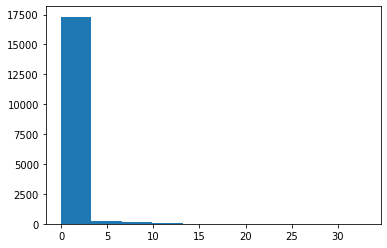

(array([3.1399e+04, 4.3400e+02, 1.4200e+02, 5.5000e+01, 3.0000e+01,
        2.8000e+01, 1.2000e+01, 5.0000e+00, 5.0000e+00, 1.1000e+01]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <BarContainer object of 10 artists>)

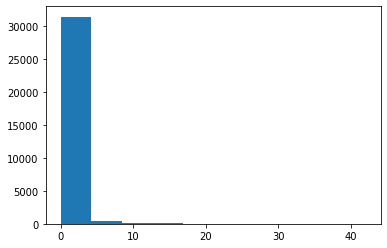

In [26]:
flag = "eltv_90.50239377618193_flag_y"
fpm = dfOrig[dfOrig["prepayment_type_FullPrepayment"] == 1].index.to_list()
ppm=dfOrig[dfOrig["prepayment_type_PartialPrepayment"] == 1].index.to_list()
npm=dfOrig[dfOrig["prepayment_type_No Prepayment"] == 1].index.to_list()

fpm_flag_values = dfOrig.loc[dfOrig.index.isin(fpm), flag].values
ppm_flag_values = dfOrig.loc[dfOrig.index.isin(ppm), flag].values
npm_flag_values = dfOrig.loc[dfOrig.index.isin(npm), flag].values


plt.hist(ppm_flag_values)
plt.show()
plt.hist(no_ppm_flag_values)

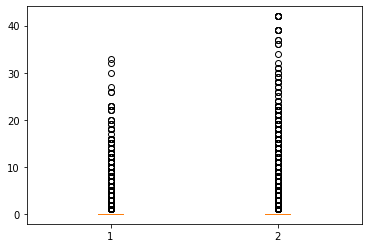

In [29]:
plt.boxplot([ppm_flag_values,no_ppm_flag_values])
plt.xticks([1, 2, 3, 4],[Full prepayment, No Full prepayment]
plt.show()

In [25]:
list(dfOrig.columns)

['fico',
 'mi_pct',
 'cnt_units',
 'cltv',
 'dti',
 'orig_upb',
 'ltv',
 'int_rt',
 'ppmt_pnlty',
 'orig_loan_term',
 'cnt_borr',
 'flag_sc',
 'Property_valuation_method',
 'scheduled_payments',
 'flag_fthb_9',
 'flag_fthb_N',
 'flag_fthb_Y',
 'occpy_sts_I',
 'occpy_sts_P',
 'occpy_sts_S',
 'channel_B',
 'channel_C',
 'channel_R',
 'prod_type_FRM',
 'st_AK',
 'st_AL',
 'st_AR',
 'st_AZ',
 'st_CA',
 'st_CO',
 'st_CT',
 'st_DC',
 'st_DE',
 'st_FL',
 'st_GA',
 'st_GU',
 'st_HI',
 'st_IA',
 'st_ID',
 'st_IL',
 'st_IN',
 'st_KS',
 'st_KY',
 'st_LA',
 'st_MA',
 'st_MD',
 'st_ME',
 'st_MI',
 'st_MN',
 'st_MO',
 'st_MS',
 'st_MT',
 'st_NC',
 'st_ND',
 'st_NE',
 'st_NH',
 'st_NJ',
 'st_NM',
 'st_NV',
 'st_NY',
 'st_OH',
 'st_OK',
 'st_OR',
 'st_PA',
 'st_PR',
 'st_RI',
 'st_SC',
 'st_SD',
 'st_TN',
 'st_TX',
 'st_UT',
 'st_VA',
 'st_VI',
 'st_VT',
 'st_WA',
 'st_WI',
 'st_WV',
 'st_WY',
 'prop_type_CO',
 'prop_type_CP',
 'prop_type_MH',
 'prop_type_PU',
 'prop_type_SF',
 'loan_purpose_C',
 'loa